In [2]:
import pandas as pd
import numpy as np
import nltk
from datetime import date
from nltk.corpus import stopwords
import re
import string
import time
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

## Read Data

In [3]:
Jobs = pd.read_csv("Job_sample.csv")
Jobs.columns = [c.replace(' ', '_') for c in Jobs.columns]
Jobs = Jobs.rename(columns={'id': 'Job_id'})
Jobs.head()

,Job_id,Job_Roles_,Country_Code_,glints_joborder_created_date,Skills_Required_,Year_of_Experience_Requirement__
0,1,Software_Engineer,MISSING_COUNTRY_CODE,2019-06-20T08:38:37.43,".NET, .NET, .NET_Core",6
1,2,Product_Manager,ID,2022-01-19T07:22:32.822,"Jira, Scrum, Product_Management",3
2,3,Software_Engineer,ID,2021-10-22T09:48:58.893,React.js,2
3,4,Full-Stack_Developer,VN,2021-08-26T08:29:18.147,"Vue.js, PHP",2
4,5,Research_&_Development,ID,2021-09-15T06:43:24.815,"Analysis, Analytical_Skills, Research",1


In [4]:
Candidate = pd.read_csv("Candidate_sample.csv")
Candidate.columns = [c.replace(' ', '_') for c in Candidate.columns]
Candidate = Candidate.rename(columns={'id': 'Candidate_id'})
Candidate.head()

,Candidate_id,glints_mergedprofile_country_code,Work_Experience_Title_,Skills_,Days_since_last_seen,Profile_Creation_Date,Days_of_experience
0,1,ID,Junior Aktivasi,"Cisco_Packet_Tracer, Communication, CSS, Fiber...",323,2021-04-23T20:37:07.762,1081.00
1,2,SG,Human Resource intern Marketing intern,"Administration, Communication, Detail_Oriented...",1,2022-01-28T09:40:38.837,166.00
2,3,ID,MISSING_WORK_EXPERIENCE_TITLES,"Communication, English, Microsoft_Excel, Micro...",52,2022-03-18T06:15:53.818,-1.00
3,4,ID,Kondektur Bus Sekolah,"English, Presentation_Skills, Public_Speaking,...",816,2019-10-16T09:45:49.116,2068.75
4,5,ID,Bagian Umum Editor,"Adobe_Photoshop, Corel_Draw_Suite, Editor, Med...",7,2022-05-18T10:42:22.182,365.25


## EDA

<strong><span style="color:Red"> Missing Values </span></strong>:  
- Country codes for 58 of 161 Jobs are missing (36%)  
- Candidate skills for 484 of 1960 candidates are missing (25%)
- Candidate Work titles for 634 of 1960 candidates are missing  (32%)

In [5]:
Jobs.count()  #161
Jobs[Jobs['Country_Code_'] == 'MISSING_COUNTRY_CODE'].count()   #58
Jobs[Jobs['Country_Code_'] == 'MISSING_COUNTRY_CODE'].head()

,Job_id,Job_Roles_,Country_Code_,glints_joborder_created_date,Skills_Required_,Year_of_Experience_Requirement__
0,1,Software_Engineer,MISSING_COUNTRY_CODE,2019-06-20T08:38:37.43,".NET, .NET, .NET_Core",6
6,7,DevOps,MISSING_COUNTRY_CODE,2020-07-13T08:46:11.051,"DevOps, Amazon_Web_Services_(AWS), Linux_Syste...",7
9,10,Network_Engineer,MISSING_COUNTRY_CODE,2021-08-31T11:55:04.816,"Network_Security, Switching, Routing, Networking",2
10,11,Android_Developer,MISSING_COUNTRY_CODE,2020-07-13T12:50:04.394,Kotlin,2
13,14,Digital_Marketing,MISSING_COUNTRY_CODE,2022-01-27T06:42:29.767,"Management, Customer_Relationship_Management_(...",3


In [6]:
Candidate.count()  #1960
Candidate[Candidate['Skills_'] == 'MISSING_SKILLS'].count()   #484
Candidate[Candidate['Work_Experience_Title_'] == 'MISSING_WORK_EXPERIENCE_TITLES'].count()  #634
Candidate[Candidate['Skills_'] == 'MISSING_SKILLS'].head() 

,Candidate_id,glints_mergedprofile_country_code,Work_Experience_Title_,Skills_,Days_since_last_seen,Profile_Creation_Date,Days_of_experience
13,14,VN,Fundamental Business Analysis course Accor Pro...,MISSING_SKILLS,473,2021-02-28T05:06:12.657,1461.0
22,23,VN,MISSING_WORK_EXPERIENCE_TITLES,MISSING_SKILLS,123,2021-10-14T10:54:59.237,-1.0
23,24,ID,MISSING_WORK_EXPERIENCE_TITLES,MISSING_SKILLS,180,2021-12-17T17:51:39.057,-1.0
27,28,VN,MISSING_WORK_EXPERIENCE_TITLES,MISSING_SKILLS,136,2022-01-30T14:50:52.9,-1.0
32,33,SG,MISSING_WORK_EXPERIENCE_TITLES,MISSING_SKILLS,1935,2017-02-26T11:17:09.266,-1.0


In [7]:
pd.DataFrame(Candidate.groupby(['Days_since_last_seen'])['Candidate_id'].count()).head(9)

,Candidate_id
Days_since_last_seen,
-1,111
0,24
1,22
2,17
3,7
4,4
5,9
6,12
7,10


## Feature Engineering

<strong><span style="color:Blue"> Time feature </span></strong>:  
- Candidate experience in days is converted into years  
- #Months when profile was created is obtained from Profile_Creation_Date
- Days_since_last_seen is converted into Weeks_since_last_seen since to increase readability and if a candidate was last seen 2 days ago vs 6 days ago should not imply much difference

In [8]:
Jobs['time'] = pd.to_datetime(Jobs['glints_joborder_created_date'])
Jobs['dates'] = Jobs['time'].dt.date
Jobs['Job_created_mo'] = ((date.today()-Jobs['dates'])/np.timedelta64(1, 'M'))
Jobs['Job_created_mo'] = Jobs['Job_created_mo'].astype(int)
Jobs.head()

,Job_id,Job_Roles_,Country_Code_,glints_joborder_created_date,Skills_Required_,Year_of_Experience_Requirement__,time,dates,Job_created_mo
0,1,Software_Engineer,MISSING_COUNTRY_CODE,2019-06-20T08:38:37.43,".NET, .NET, .NET_Core",6,2019-06-20 08:38:37.430,2019-06-20,37
1,2,Product_Manager,ID,2022-01-19T07:22:32.822,"Jira, Scrum, Product_Management",3,2022-01-19 07:22:32.822,2022-01-19,6
2,3,Software_Engineer,ID,2021-10-22T09:48:58.893,React.js,2,2021-10-22 09:48:58.893,2021-10-22,9
3,4,Full-Stack_Developer,VN,2021-08-26T08:29:18.147,"Vue.js, PHP",2,2021-08-26 08:29:18.147,2021-08-26,11
4,5,Research_&_Development,ID,2021-09-15T06:43:24.815,"Analysis, Analytical_Skills, Research",1,2021-09-15 06:43:24.815,2021-09-15,10


In [9]:
Candidate['time'] = pd.to_datetime(Candidate['Profile_Creation_Date'])
Candidate['dates'] = Candidate['time'].dt.date
Candidate['Profile_created_mo'] = ((date.today()-Candidate['dates'])/np.timedelta64(1, 'M'))
Candidate['Profile_created_mo'] = Candidate['Profile_created_mo'].astype(int)
Candidate['Experience_in_yrs'] = (Candidate['Days_of_experience']/365).astype(int)
Candidate['Weeks_since_last_seen'] = (Candidate['Days_since_last_seen']/7).astype(int)
Candidate.head()

,Candidate_id,glints_mergedprofile_country_code,Work_Experience_Title_,Skills_,Days_since_last_seen,Profile_Creation_Date,Days_of_experience,time,dates,Profile_created_mo,Experience_in_yrs,Weeks_since_last_seen
0,1,ID,Junior Aktivasi,"Cisco_Packet_Tracer, Communication, CSS, Fiber...",323,2021-04-23T20:37:07.762,1081.00,2021-04-23 20:37:07.762,2021-04-23,15,2,46
1,2,SG,Human Resource intern Marketing intern,"Administration, Communication, Detail_Oriented...",1,2022-01-28T09:40:38.837,166.00,2022-01-28 09:40:38.837,2022-01-28,6,0,0
2,3,ID,MISSING_WORK_EXPERIENCE_TITLES,"Communication, English, Microsoft_Excel, Micro...",52,2022-03-18T06:15:53.818,-1.00,2022-03-18 06:15:53.818,2022-03-18,4,0,7
3,4,ID,Kondektur Bus Sekolah,"English, Presentation_Skills, Public_Speaking,...",816,2019-10-16T09:45:49.116,2068.75,2019-10-16 09:45:49.116,2019-10-16,33,5,116
4,5,ID,Bagian Umum Editor,"Adobe_Photoshop, Corel_Draw_Suite, Editor, Med...",7,2022-05-18T10:42:22.182,365.25,2022-05-18 10:42:22.182,2022-05-18,2,1,1


## Task 1: Methodology chosen - Content based Recommender System¶

<div class="alert alert-block alert-info">
<b> Why Content Based System </b></div>

- There are broadly 3 types of recommender systems - Collaborative Filtering , Content based and Hybrid System.
- For Collaborative filtering & Hybrid System , an implicit feedback is required which is often a numerical value which denotes affinity of a user (here Candidate) to an item (here Job)
- In the shared dataset, we do have information like profile_created , Last_seen and Candidate Experiences alone but that cannot help us match required Job with the suitable Candidate as per their Skills & Job title 
- Hence it makes sense to use Content based RecSys since it can help us match the Job with a suitable candidate basis her Skills and other text information

<div class="alert alert-block alert-info">
<b> How to implement </b></div>

- Get relevant text data for both Jobs (Job_role , Skills required , Country code) and Candidates (Work title , Skills , Country code) dataset
- Get their feature vector using any NLP techniques like BOW , TF-IDF or Word2vec.
- Calculate cosine similiary between each Job vector vs Candidate vector and sort it basis these scores
- Filter the top-N Candidates bases their score
- As an additional filter , we can also filter candidates basis their matching country code with the Job country code and last_seen_activity

## Create corpus

In [10]:
Jobs['Job_Roles_'] = Jobs['Job_Roles_'].replace('_',' ', regex=True)
Jobs['Job_Roles_'] = Jobs['Job_Roles_'].replace('-',' ', regex=True)

Jobs["Jtext"] = Jobs["Job_Roles_"].map(str) + " " + Jobs["Skills_Required_"] +" "+ Jobs["Country_Code_"]
Jobs = Jobs[['Job_id','Country_Code_','Job_Roles_','Jtext','Job_created_mo','Skills_Required_','Year_of_Experience_Requirement__']]
Jobs.head()

,Job_id,Country_Code_,Job_Roles_,Jtext,Job_created_mo,Skills_Required_,Year_of_Experience_Requirement__
0,1,MISSING_COUNTRY_CODE,Software Engineer,"Software Engineer .NET, .NET, .NET_Core MISSIN...",37,".NET, .NET, .NET_Core",6
1,2,ID,Product Manager,"Product Manager Jira, Scrum, Product_Managemen...",6,"Jira, Scrum, Product_Management",3
2,3,ID,Software Engineer,Software Engineer React.js ID,9,React.js,2
3,4,VN,Full Stack Developer,"Full Stack Developer Vue.js, PHP VN",11,"Vue.js, PHP",2
4,5,ID,Research & Development,"Research & Development Analysis, Analytical_Sk...",10,"Analysis, Analytical_Skills, Research",1


In [11]:
Candidate["Ctext"] = Candidate["Work_Experience_Title_"].map(str) + " " + Candidate["Skills_"] +" "+ Candidate["glints_mergedprofile_country_code"]
Candidate = Candidate[['Candidate_id','glints_mergedprofile_country_code','Skills_','Work_Experience_Title_','Ctext',
                       'Profile_created_mo','Experience_in_yrs','Weeks_since_last_seen']]

Candidate.head()

,Candidate_id,glints_mergedprofile_country_code,Skills_,Work_Experience_Title_,Ctext,Profile_created_mo,Experience_in_yrs,Weeks_since_last_seen
0,1,ID,"Cisco_Packet_Tracer, Communication, CSS, Fiber...",Junior Aktivasi,"Junior Aktivasi Cisco_Packet_Tracer, Communica...",15,2,46
1,2,SG,"Administration, Communication, Detail_Oriented...",Human Resource intern Marketing intern,Human Resource intern Marketing intern Adminis...,6,0,0
2,3,ID,"Communication, English, Microsoft_Excel, Micro...",MISSING_WORK_EXPERIENCE_TITLES,"MISSING_WORK_EXPERIENCE_TITLES Communication, ...",4,0,7
3,4,ID,"English, Presentation_Skills, Public_Speaking,...",Kondektur Bus Sekolah,"Kondektur Bus Sekolah English, Presentation_Sk...",33,5,116
4,5,ID,"Adobe_Photoshop, Corel_Draw_Suite, Editor, Med...",Bagian Umum Editor,"Bagian Umum Editor Adobe_Photoshop, Corel_Draw...",2,1,1


## Clean corpus

In [12]:
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text) 
  text = text.replace("nbsp", "")
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

Jobs['Jtext'] = Jobs['Jtext'].apply(clean_txt)
Jobs.head()

,Job_id,Country_Code_,Job_Roles_,Jtext,Job_created_mo,Skills_Required_,Year_of_Experience_Requirement__
0,1,MISSING_COUNTRY_CODE,Software Engineer,software engineer net net net_core missing_cou...,37,".NET, .NET, .NET_Core",6
1,2,ID,Product Manager,product manager jira scrum product_management,6,"Jira, Scrum, Product_Management",3
2,3,ID,Software Engineer,software engineer react,9,React.js,2
3,4,VN,Full Stack Developer,full stack developer vue php,11,"Vue.js, PHP",2
4,5,ID,Research & Development,research development analysis analytical_skill...,10,"Analysis, Analytical_Skills, Research",1


In [13]:
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text) 
  text = text.replace("nbsp", "")
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

Candidate['Ctext'] = Candidate['Ctext'].apply(clean_txt)
Candidate[Candidate['Candidate_id']==292].head()

,Candidate_id,glints_mergedprofile_country_code,Skills_,Work_Experience_Title_,Ctext,Profile_created_mo,Experience_in_yrs,Weeks_since_last_seen
291,292,ID,"Communication, Marketing, Microsoft_Office, My...",Software Development Engineer Business Develop...,software development engineer business develop...,30,6,119


## TF IDF vectors

In [14]:
tfidf_vectorizer = TfidfVectorizer()

In [15]:
tfidf_candidate = tfidf_vectorizer.fit_transform((Candidate['Ctext'])) #fitting and transforming the vector
tfidf_candidate.shape

(1960, 4162)

## Task 2 : Handling missing values¶

<div class="alert alert-block alert-info">

- Calculate Cosine similarity between different Candidate TF-IDF vectors
- Pick the most similar candidate as per these scores, chances are the candidates with the missing values will have the same Work experince, Skills etc as the most similar Candidate vector  </div>

In [16]:
def Missing_values_imputer(df,Id_col,Missing_column,Missing_column_values,tf_idf,text):
    
    def Nearest_value_finder(top, df, scores,Missing_Id):
        nearest = pd.DataFrame(columns = ['Missing_id','Matched_id',Missing_column,'score'])
        count = 0
        for i in top:
            nearest.at[count, 'Missing_id'] = Missing_Id
            nearest.at[count, 'Matched_id'] = df[Id_col][i]
            nearest.at[count, Missing_column] = df[Missing_column][i]
            nearest.at[count, 'score'] =  scores[count]
            count += 1
        return nearest

    nearest_df = pd.DataFrame(['Missing_id','Matched_id',Missing_column,'score'])
    df_list = df[df[Missing_column] == Missing_column_values]
    df_list = df_list[Id_col][1:5].unique()
    
#     return df_list

    for ID in df_list:
        missing_tf_idf = tfidf_vectorizer.transform(df[df[Id_col] == ID][text])
        cos_similarity_tfidf = map(lambda x: cosine_similarity(missing_tf_idf, x),tf_idf)
        output2 = list(cos_similarity_tfidf)

        top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)
        list_scores = [output2[i][0][0] for i in top]
        nearest_df = nearest_df.append(pd.DataFrame(Nearest_value_finder(top,df, list_scores,ID)))

    nearest_df = nearest_df[['Missing_id','Matched_id',Missing_column,'score']]
    nearest_df = nearest_df.dropna()
    nearest_df.fillna(0,inplace=True)
    nearest_df = nearest_df[nearest_df[Missing_column] != Missing_column_values]
    nearest_df = nearest_df.groupby(['Missing_id']).head(1)
    return nearest_df

Missing_WorkEx = Missing_values_imputer(Candidate,'Candidate_id','Work_Experience_Title_','MISSING_WORK_EXPERIENCE_TITLES',tfidf_candidate,'Ctext')
# Missing_Candidate_skills = Missing_values_imputer(Candidate,'Candidate_id','Skills_','MISSING_SKILLS',tfidf_candidate,'Ctext')
# Missing_job_skills = Missing_values_imputer(Jobs,'Job_id','Skills_Required_','MISSING_SKILLS',tfidf_job,'Jtext')
# Missing_country = Missing_values_imputer(Jobs,'Job_id','Country_code_','MISSING_COUNTRY_CODE',tfidf_job,'Jtext')

Missing_WorkEx.head(10)


,Missing_id,Matched_id,Work_Experience_Title_,score
2,12,118,Assistant for Accounting Supervisor,0.641984
372,19,295,Marketing,0.380932
4,20,961,Staff Accounting,0.769941
304,23,778,R&D,0.747895


- Here Candidate_id with ID 12 has missing Work_exp but it should be most similar to Candidate_id 118 as shown below

In [47]:
Candidate[Candidate['Candidate_id'] == 12].head()

,Candidate_id,glints_mergedprofile_country_code,Skills_,Work_Experience_Title_,Ctext,Profile_created_mo,Experience_in_yrs,Weeks_since_last_seen
11,12,ID,"Accounting, Communication, Detail_Oriented, Fi...",MISSING_WORK_EXPERIENCE_TITLES,missing_work_experience_titles account communi...,33,0,136


In [48]:
Candidate[Candidate['Candidate_id'] == 118].head()

,Candidate_id,glints_mergedprofile_country_code,Skills_,Work_Experience_Title_,Ctext,Profile_created_mo,Experience_in_yrs,Weeks_since_last_seen
117,118,ID,"Accounting, Communication, Detail_Oriented, Fi...",Assistant for Accounting Supervisor,assistant account supervisor account communica...,17,8,68


## Top N recommended candidates for each Job using cosine similarity

In [17]:
def get_recommendation(top, df_all, scores,job_id):
  recommendation = pd.DataFrame(columns = ['Candidate_id', 'Job_id',  'Job_Roles_', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'Job_id'] = job_id
      recommendation.at[count, 'Candidate_id'] = df_all['Candidate_id'][i]
      #recommendation.at[count, 'Job_Roles_'] = df_all['Job_Roles_'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

In [18]:
rec_df = pd.DataFrame(['Candidate_id','Job_id','Job_Roles_','score'])

job_list = Jobs['Job_id'].unique()
#job_list = Jobs['Job_id'][1:10].unique()

for job_id in job_list:
    tfidf_job = tfidf_vectorizer.transform(Jobs[Jobs['Job_id'] == job_id]['Jtext'])
    cos_similarity_tfidf = map(lambda x: cosine_similarity(tfidf_job, x),tfidf_candidate)
    output2 = list(cos_similarity_tfidf)

    top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)
    list_scores = [output2[i][0][0] for i in top]
    rec_df = rec_df.append(pd.DataFrame(get_recommendation(top,Candidate, list_scores,job_id)))

rec_df = rec_df[['Job_id','Candidate_id','score']]
rec_df = rec_df.dropna()
rec_df.fillna(0,inplace=True)
#rec_df = rec_df[rec_df['score'] > 0]
rec_df.head()

,Job_id,Candidate_id,score
0,1,979,0.606158
1,1,71,0.492805
2,1,293,0.373916
3,1,1896,0.364500
4,1,898,0.349587


#### Append last seen, profile created , experience and job posted timetamps

In [19]:
Final_df = Jobs.merge(rec_df,how ="left",on='Job_id')
Final_df = Final_df.merge(Candidate,how ="left",on='Candidate_id')
Final_df = Final_df[['Job_id','Candidate_id','Job_Roles_','Country_Code_','glints_mergedprofile_country_code'
                    ,'Work_Experience_Title_','Year_of_Experience_Requirement__','Experience_in_yrs',
                     'Skills_Required_','Skills_','Profile_created_mo','Weeks_since_last_seen','score']]
Final_df = Final_df.rename(columns={'Job_Roles_': 'Job_Role',
                                    'Country_Code_' : 'Job_country',
                                   'glints_mergedprofile_country_code' : 'Candidate_country' ,
                                   'Work_Experience_Title_' : 'Candidate_job_title',
                                   'Year_of_Experience_Requirement__' : 'Exp_required',
                                   'Skills_Required_' : 'Skills_required',
                                   'Skills_' : 'Candidate_skills',
                                   'Experience_in_yrs' : 'Candidate_exp'})
Final_df.head()
Final_df.to_csv('Recommendations.csv')

In [20]:
Final_df['Candidate_id'].isna().sum()

0

## Task 3 : Case 1 (Predict Likelihood of Candidates being open to ANY Job postings using Kmeans)

<div class="alert alert-block alert-info">
<b>Making predictions basis just the Last_seen information since it would denote how proactively the candidate is looking for a job change </b> </div>

In [21]:
Candidate_last_seen = Candidate[['Candidate_id','Weeks_since_last_seen']]
Candidate_last_seen.drop_duplicates(inplace=True)
Candidate_last_seen.set_index('Candidate_id',inplace=True)
Candidate_last_seen.head()

<ipython-input-21-b271396939fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Candidate_last_seen.drop_duplicates(inplace=True)


,Weeks_since_last_seen
Candidate_id,
1,46
2,0
3,7
4,116
5,1


## K-means for obtaining clusters

#### Outlier Treatment

In [22]:
df = Candidate_last_seen[['Weeks_since_last_seen']]

#Missing values
df = df.fillna(0)
df = df.replace([np.inf, -np.inf], np.nan)
df.isnull().values.any()

#standardize
#df_std = pd.DataFrame(StandardScaler().fit_transform(df))

df_std = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)

#Treat outliers (Removing obs that fall beyond 3 stand dev)
for col in df_std.columns:
    upper = 3
    lower = -3
    df_std[col][df_std[col] < lower] = lower
    df_std[col][df_std[col] > upper] = upper

df_std.head()

,Weeks_since_last_seen
Candidate_id,
1,-0.213412
2,-0.923945
3,-0.815821
4,0.867834
5,-0.908499


#### Elbow method for clustering

In [23]:
X = df_std[['Weeks_since_last_seen']].values

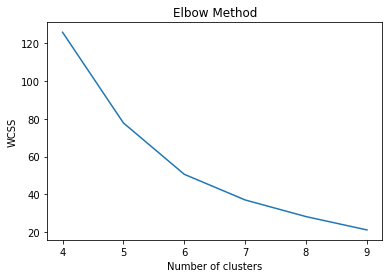

In [24]:
wcss = []
for i in range(4, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(4,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
model = KMeans(n_clusters=6,init='k-means++', max_iter=1000, n_init=6, random_state=0)
Last_seen_clusters = model.fit_predict(X)
Last_seen_clusters

array([2, 0, 0, ..., 3, 3, 3], dtype=int32)

In [26]:
Last_seen_clusters = pd.DataFrame(Last_seen_clusters,index = df_std.index,columns=['Last_seen_cluster'])

df_pred = df.join(Last_seen_clusters)
df_pred.fillna(0,inplace=True)
df_pred.head()

,Weeks_since_last_seen,Last_seen_cluster
Candidate_id,,
1,46,2
2,0,0
3,7,0
4,116,5
5,1,0


In [27]:
df_pred.groupby(['Last_seen_cluster'])['Weeks_since_last_seen'].min()

Last_seen_cluster
0      0
1    150
2     23
3     58
4    210
5    100
Name: Weeks_since_last_seen, dtype: int64

In [28]:
df_pred.groupby(['Last_seen_cluster'])['Weeks_since_last_seen'].max()

Last_seen_cluster
0     22
1    206
2     57
3     99
4    373
5    149
Name: Weeks_since_last_seen, dtype: int64

In [29]:
df_pred.loc[(df_pred['Weeks_since_last_seen'] >= 0 ) & (df_pred['Weeks_since_last_seen'] <= 22 ) , 'last_seen_weeks'] = '0 - 22'
df_pred.loc[(df_pred['Weeks_since_last_seen'] >= 23 ) & (df_pred['Weeks_since_last_seen'] <= 56 ) , 'last_seen_weeks'] = '23 - 56'
df_pred.loc[(df_pred['Weeks_since_last_seen'] >= 57 ) & (df_pred['Weeks_since_last_seen'] <= 99 ) , 'last_seen_weeks'] = '57 - 99'
df_pred.loc[(df_pred['Weeks_since_last_seen'] >= 100 ) & (df_pred['Weeks_since_last_seen'] <= 150 ) , 'last_seen_weeks'] = '100 - 150'
df_pred.loc[(df_pred['Weeks_since_last_seen'] >= 151 ) & (df_pred['Weeks_since_last_seen'] <= 206 ) , 'last_seen_weeks'] = '151 - 206'
df_pred.loc[(df_pred['Weeks_since_last_seen'] >= 210 ) & (df_pred['Weeks_since_last_seen'] <= 373 ) , 'last_seen_weeks'] = '210 - 373'

In [30]:
df_pred.head()
df_pred.count()

Weeks_since_last_seen    1960
Last_seen_cluster        1960
last_seen_weeks          1960
dtype: int64

In [31]:
# df_pred.reset_index(inplace=True,drop=True)
# colors = ['#DF2020', '#81DF20', '#2095DF','#A985AF','#F095DF','A095DF']
# df_pred['c'] = df_pred['Last_seen_cluster'].map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3], 4:colors[4], 5:colors[5]})
# plt.scatter(df_pred['Last_seen_cluster'], df_pred['Weeks_since_last_seen'], c=df_pred['c'].values, alpha = 0.6, s=10)

<code style="background:yellow;color:black"><b>Customers who were last seen between 0-22 weeks are most likely to be open for job openings </b></code> 

## Task 3 : Case 2 (Predict Likelihood of Candidates being open to A SPECIFIC Job postings using KPrototypes)

<div class="alert alert-block alert-info">
<b>Making predictions basis all relevant information including JOB ID since the prediction need to be Job specific </b> </div>

In [32]:
df = Final_df[['Candidate_id','Job_id','Exp_required','Candidate_exp','Weeks_since_last_seen','score']]
df.dropna(inplace=True)
df = df.set_index(['Candidate_id','Job_id'])
df.head()

<ipython-input-32-84f4b915edd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,,Exp_required,Candidate_exp,Weeks_since_last_seen,score
Candidate_id,Job_id,,,,
979,1,6,18,115,0.606158
71,1,6,8,75,0.492805
293,1,6,7,74,0.373916
1896,1,6,6,0,0.364500
898,1,6,14,74,0.349587


#### Outlier treatment

In [33]:
#Missing values
df = df.fillna(0)
df = df.replace([np.inf, -np.inf], np.nan)
df.isnull().values.any()

#standardize
#df_std = pd.DataFrame(StandardScaler().fit_transform(df))

df_std = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)

#Treat outliers (Removing obs that fall beyond 3 stand dev)
for col in df_std.columns:
    upper = 3
    lower = -3
    df_std[col][df_std[col] < lower] = lower
    df_std[col][df_std[col] > upper] = upper

df_std.head()

,,Exp_required,Candidate_exp,Weeks_since_last_seen,score
Candidate_id,Job_id,,,,
979,1,1.167581,2.663652,0.852387,3.0
71,1,1.167581,0.755899,0.234533,3.0
293,1,1.167581,0.565123,0.219086,3.0
1896,1,1.167581,0.374348,-0.923945,3.0
898,1,1.167581,1.900551,0.219086,3.0


In [34]:
df2 = df_std.reset_index()
df2.set_index('Candidate_id',inplace=True)
# df2.head()
df2['Job_id'] = df2['Job_id'].astype(str)
df2.head()
#df2.dtypes

,Job_id,Exp_required,Candidate_exp,Weeks_since_last_seen,score
Candidate_id,,,,,
979,1,1.167581,2.663652,0.852387,3.0
71,1,1.167581,0.755899,0.234533,3.0
293,1,1.167581,0.565123,0.219086,3.0
1896,1,1.167581,0.374348,-0.923945,3.0
898,1,1.167581,1.900551,0.219086,3.0


In [35]:
X=df2.values
X

array([['1', 1.167580614787185, 2.663652124914918, 0.8523874165749968,
        3.0],
       ['1', 1.167580614787185, 0.755898648033664, 0.23453263237122696,
        3.0],
       ['1', 1.167580614787185, 0.5651233003455387, 0.21908626276613272,
        3.0],
       ...,
       ['161', -1.2993548049075236, -0.7703041334713389,
        0.049176197110095986, -0.2674865409262955],
       ['161', -1.2993548049075236, 0.3743479526574133,
        0.6052455028934889, -0.2674865409262955],
       ['161', -1.2993548049075236, -0.5795287857832134,
        0.35810358921198093, -0.2674865409262955]], dtype=object)

## Kprototype for obtaining Clusters

#### Decide optimal clusters

In [36]:
categorical_index = [0]

In [37]:
# # Function for plotting elbow curve
# def plot_elbow_curve(start, end, data):
#     no_of_clusters = list(range(start, end+1))
#     cost_values = []
    
#     for k in no_of_clusters:
#         test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
#         test_model.fit_predict(data, categorical=categorical_index)
#         cost_values.append(test_model.cost_)
        
#     sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
#     plt.figure(figsize=(15, 7))
#     ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
#     ax.set_title('Elbow curve', fontsize=18)
#     ax.set_xlabel('No of clusters', fontsize=14)
#     ax.set_ylabel('Cost', fontsize=14)
#     ax.set(xlim=(start-0.1, end+0.1))
#     plt.plot();
    
# # Plotting elbow curve for k=2 to k=10
# plot_elbow_curve(4,10,X)

In [38]:
start_time = time.time()
start_time

model = KPrototypes(n_clusters=5, init='Huang', random_state=42, n_jobs=-1,verbose=True)
model.fit_predict(X, categorical=categorical_index)
print(model.cost_)

print("--- %s seconds ---" % (time.time() - start_time))

Best run was number 4
510991.55439440766
--- 973.3187763690948 seconds ---


In [39]:
clusters = pd.DataFrame(model.labels_,index = df_std.index,columns=['clusters'])

df_pred = df.join(clusters)
df_pred.fillna(0,inplace=True)
df_pred.head()

,,Exp_required,Candidate_exp,Weeks_since_last_seen,score,clusters
Candidate_id,Job_id,,,,,
979,1,6,18,115,0.606158,4
71,1,6,8,75,0.492805,4
293,1,6,7,74,0.373916,4
1896,1,6,6,0,0.364500,4
898,1,6,14,74,0.349587,4


In [40]:
df_pred.groupby(['clusters'])['Exp_required','Candidate_exp','Weeks_since_last_seen','score'].min()

<ipython-input-40-5fa42b9b3b58>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pred.groupby(['clusters'])['Exp_required','Candidate_exp','Weeks_since_last_seen','score'].min()


,Exp_required,Candidate_exp,Weeks_since_last_seen,score
clusters,,,,
0,1,0,0,0.000000
1,1,7,0,0.000000
2,1,0,86,0.000000
3,5,0,0,0.000000
4,1,0,0,0.057346


In [41]:
df_pred.reset_index(inplace=True)
colors = ['#DF2020', '#81DF20', '#2095DF','#A985AF','#F095DF']
df_pred2 = df_pred
df_pred2['c'] = df_pred.clusters.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3], 4:colors[4]})

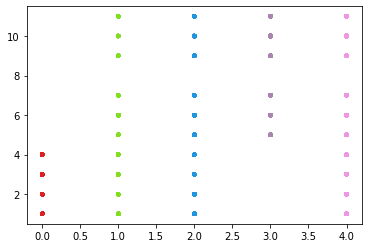

In [42]:
plt.scatter(df_pred2['clusters'], df_pred2['Exp_required'], c=df_pred2.c, alpha = 0.6, s=10)

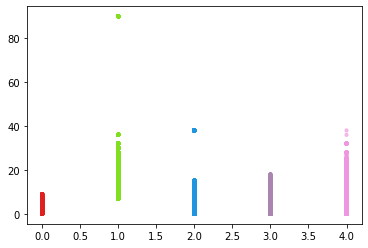

In [43]:
plt.scatter(df_pred2['clusters'], df_pred2['Candidate_exp'], c=df_pred2.c, alpha = 0.6, s=10)

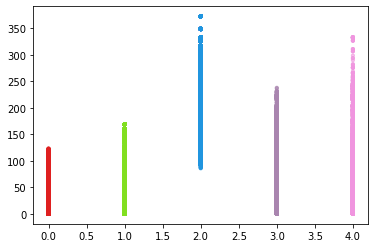

In [44]:
plt.scatter(df_pred2['clusters'], df_pred2['Weeks_since_last_seen'], c=df_pred2.c, alpha = 0.6, s=10)

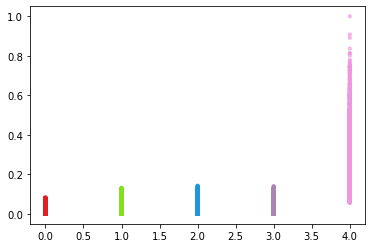

In [45]:
plt.scatter(df_pred2['clusters'], df_pred2['score'], c=df_pred2.c, alpha = 0.6, s=10)

<code style="background:yellow;color:black"><b>Inference </b></code> 

- Cluster 4 seems to be the only cluster that has  higher Job vs Candidate match (>.2)
- We can candidates from cluster 4 where score > .5 and last_seen < 4 (they were last seen within a month) and whose experience is somewhere close to required Job experience

In [49]:
df_pred2[(df_pred2['clusters'] == 4) & (df_pred2['Weeks_since_last_seen'] <=4) & (df_pred2['score'] >= .5)].head()

,Candidate_id,Job_id,Exp_required,Candidate_exp,Weeks_since_last_seen,score,clusters,c
3920,1687,3,2,7,0,0.595328,4,#F095DF
5880,174,4,2,2,2,0.752767,4,#F095DF
7840,1146,5,1,0,0,0.565995,4,#F095DF
17640,1207,10,2,1,0,0.890725,4,#F095DF
19600,251,11,2,9,0,0.778986,4,#F095DF
